In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
L = 60 # (m) Bridge span
delT = 0.005 # (s) time-step

In [3]:
M = 2000 #(kg/m) mass per unit length
m = 0.5*M*L # (kg) modal mass of mode
xi = 0.025 # damping ratio
fn = 2.5 # (Hz) bridge modal frequency
wn = 2*math.pi*2.5 # (rads/s) angular modal frequency
wd = wn*math.sqrt(1-xi**2) # (rads/s) damped angular modal frequency

In [4]:
# Define the Duhamel integration function
def Duhamel(T, F):
    # Initialize an array to store displacement values
    U = np.zeros(len(T))

    # Initialize variables for cumulative sums used to calculate A and B
    ACum_i = 0
    BCum_i = 0

    # Loop through the time vector to compute the response at each time point
    for i, t in enumerate(T):

        if i > 0:
            # Calculate A[i]
            y_i = math.e**(xi * wn * T[i]) * F[i] * math.cos(wd * T[i])  # Value of integrand at current time-step
            y_iml = math.e**(xi * wn * T[i-1]) * F[i-1] * math.cos(wd * T[i-1])  # Value of integrand at previous time-step
            Area_i = 0.5 * delT * (y_i + y_iml)  # Area of the trapezoid
            ACum_i += Area_i  # Cumulative areas from t=0 to the current time
            A_i = (1 / (m * wd)) * ACum_i  # Value of A for the current time-step

            # Calculate B[i]
            y_i = math.e**(xi * wn * T[i]) * F[i] * math.sin(wd * T[i])  # Value of integrand at current time-step
            y_iml = math.e**(xi * wn * T[i-1]) * F[i-1] * math.sin(wd * T[i-1])  # Value of integrand at previous time-step
            Area_i = 0.5 * delT * (y_i + y_iml)  # Area of the trapezoid
            BCum_i += Area_i  # Cumulative areas from t=0 to the current time
            B_i = (1 / (m * wd)) * BCum_i  # Value of B for the current time-step

            # Calculate the response
            U[i] = A_i * math.e**(-xi * wn * T[i]) * math.sin(wd * T[i]) - B_i * math.e**(-xi * wn * T[i]) * math.cos(wd * T[i])

    return U

In [5]:
def Peaks(disp, time):
    # initialize containers to hold peaks and their times
    peaks = np.empty([1, 0])
    times = np.empty([1, 0])

    # calculate slopes for each data point
    slopes = np.zeros(len(disp))
    for i, u in enumerate(disp):
        if (i<len(slopes)-1):
            slopes[i] = disp[i+1] - disp[i]

    #cycle through the all slopes and pick out the peaks
    for i, u in enumerate(slopes):
        if (i<len(slopes)-1):
            if (slopes[i+1]<0 and slopes[i]>0):
                peaks = np.append(peaks, disp[i])
                times = np.append(times, time[i])

    return [peaks, times]

## Dynamic analysis: Bridge + N pedestrian crowd

In [6]:
N = 30 # number of pedestrians that cross the bridge in the time window
window = 30*60 # (s) simulation window
buffer = 200 # (s) Additional seconds to allow simulation of response beyond window length(late finishers)
mp = 80 # (kg) pedestrian mass
G = 9.81*mp # (N) static weight of pedestrian

In [7]:
# Random variables
tStart = np.random.uniform(low=0.0, high=window, size=N) # uniforml distrubuted start times
Vp = np.random.normal(loc=1.3, scale=0.125, size=N) # normally distributed walking velocities

In [8]:
# set up the simulation time vector
tMax = window + buffer
time = np.arange(0, tMax+delT, delT)

# initialize the containers to hold the individual forces and reponses calculated for each pedestrian
crowdForce = np.zeros([N, len(time)])
crowdResponse = np.zeros([N, len(time)])

# for each pedestrian....
for i, n in enumerate(np.arange(N)):
    vp = Vp[i] # (m/s) walking velocity
    startTime = tStart[i] # (s) start time
    tCross = L/vp # (s) crossing time
    tEnd = startTime + tCross # (s) finish time

    fv = 0.35*vp**3 - 1.59*vp**2 + 2.93*vp # (Hz) pacing frequency
    DLF = 0.41*(fv - 0.95) # Dynamic load factor

    timeVector = np.arange(0, tCross+delT, delT) # time vector for the pedestrian
    Fv = G + abs(G * DLF * np.sin(2*math.pi*(fv/2)*timeVector)) # static + dynamic ground reaction force

    xp = vp*timeVector # position as a function of time
    phi = np.sin(math.pi*xp/L) # mode shape at pedestrian's location
    Fn = Fv*phi # modal force experienced by SDoF system

    response = Duhamel(timeVector, Fn) # response calculated using the duhamel integral function

    #save the ground reaction force for this pedestrian at the correct position in the overall simulation records
    iStart = round(startTime/delT) # index for start time
    crowdForce[i, iStart:iStart+len(Fn)] = Fn
    crowdResponse[i, iStart:iStart+len(Fn)] = response


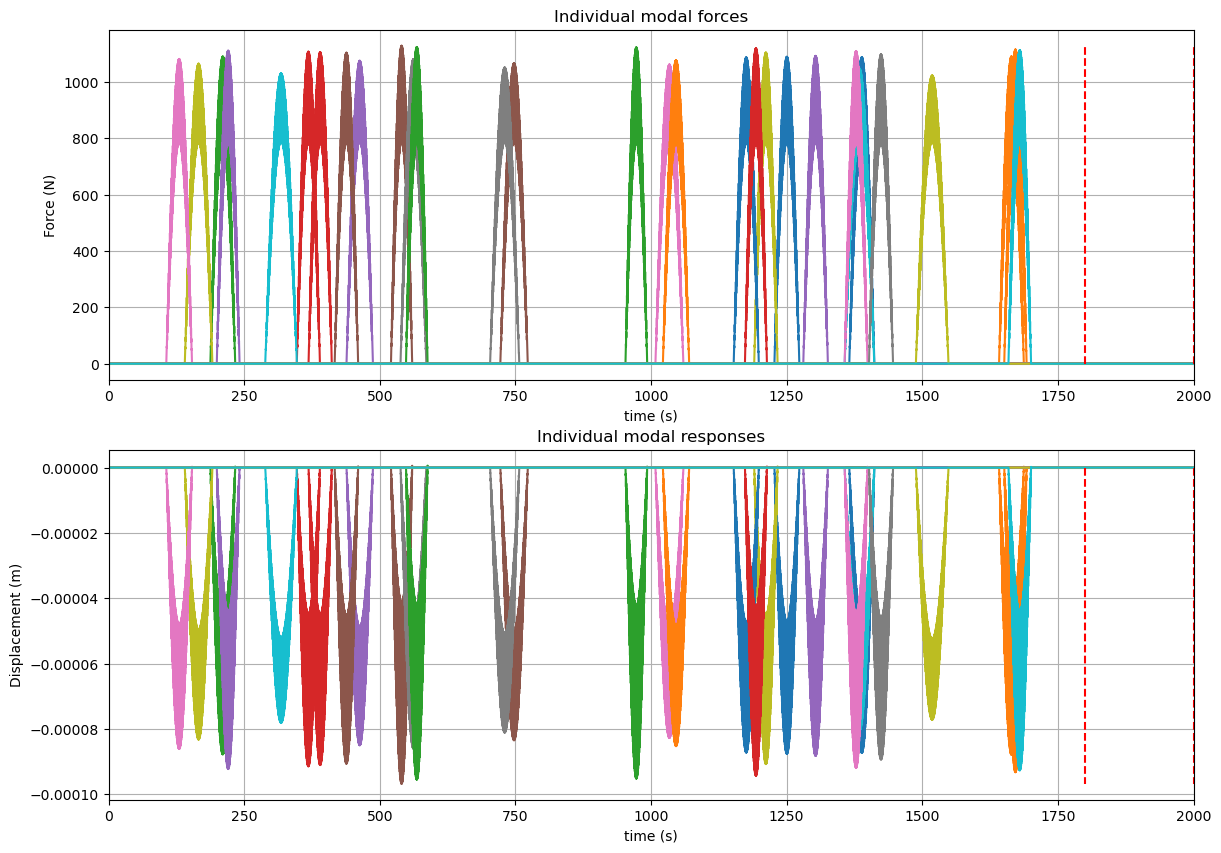

In [9]:
fig, axes = plt.subplots(figsize=(14,10), nrows=2, ncols=1)

for i in np.arange(len(crowdForce)):
    axes[0].plot(time, crowdForce[i, :])
    axes[1].plot(time, -crowdResponse[i, :])

axes[0].plot([window, window],[0, np.max(crowdForce)], 'r--')
axes[0].plot([window+buffer, window+buffer],[0, np.max(crowdForce)], 'r--')
axes[0].set_xlabel('time (s)')
axes[0].set_ylabel('Force (N)')
axes[0].set_title('Individual modal forces')
axes[0].set_xlim(0, tMax)
axes[0].grid()

axes[1].plot([window, window],[0, -np.max(crowdResponse)], 'r--')
axes[1].plot([window+buffer, window+buffer],[0, -np.max(crowdResponse)], 'r--')
axes[1].set_xlabel('time (s)')
axes[1].set_ylabel('Displacement (m)')
axes[1].set_title('Individual modal responses')
axes[1].set_xlim(0, tMax)
axes[1].grid()


In [10]:
# sum across rows of crowdForce and crowdResponse
F_crowd = sum(crowdForce)
Res_crowd = sum(crowdResponse)

In [11]:
peaks, times = Peaks(Res_crowd, time)

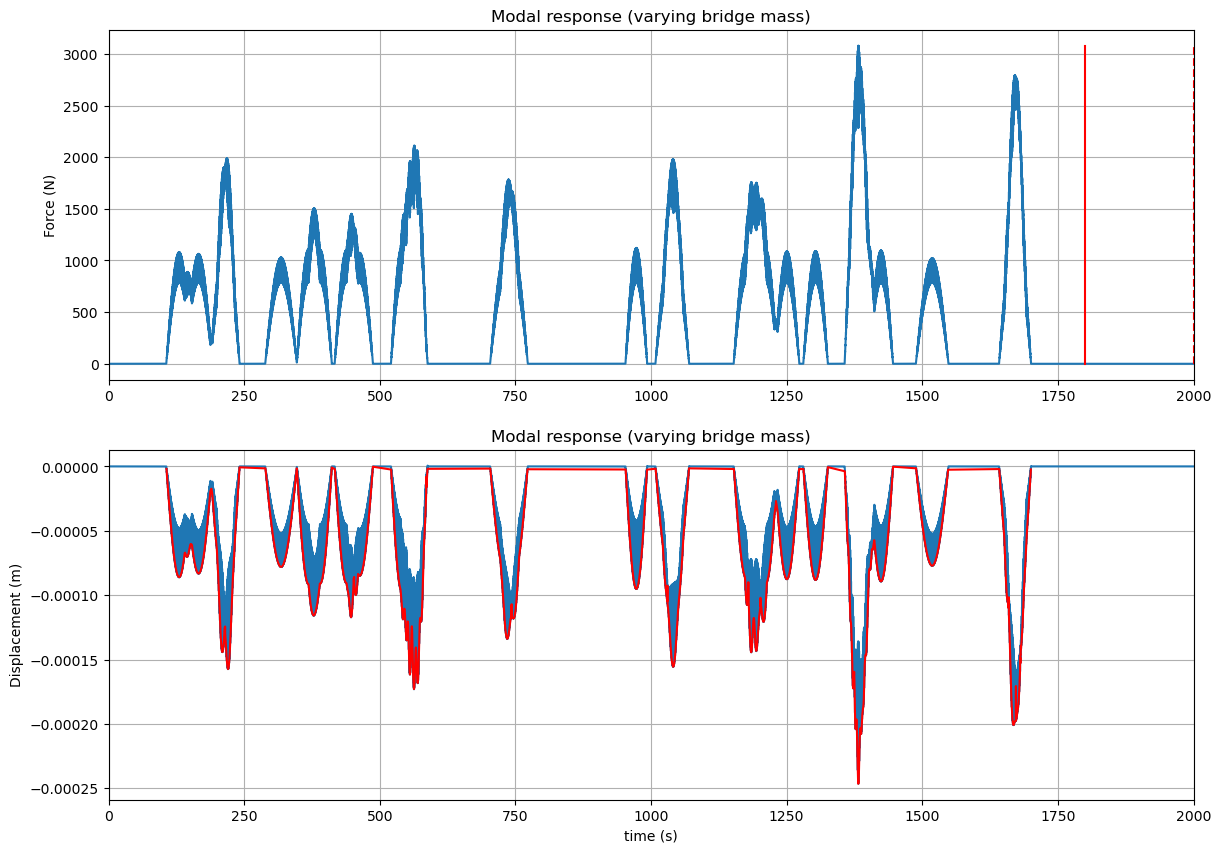

In [12]:
fig, axes = plt.subplots(figsize=(14,10), nrows=2, ncols=1)

axes[0].plot(time, F_crowd)
axes[1].plot(time, -Res_crowd)
axes[1].plot(times, -peaks, 'r-')

axes[0].plot([window, window],[0, max(F_crowd)], 'r-')
axes[0].plot([window+buffer, window+buffer],[0, max(F_crowd)], 'r--')
#axes[0].set_xlabel('time (s)')
axes[0].set_ylabel('Force (N)')
axes[0].set_title('Modal response (varying bridge mass)')
axes[0].set_xlim(0, tMax)
axes[0].grid()

axes[1].set_xlabel('time (s)')
axes[1].set_ylabel('Displacement (m)')
axes[1].set_title('Modal response (varying bridge mass)')
axes[1].set_xlim(0, tMax)
axes[1].grid()
